# Solutions

## About the data
These exercises use the [`stock_analysis`](https://github.com/stefmolin/stock-analysis) package for collection of financial data.

## Setup

In [1]:
%matplotlib inline
import stock_analysis
from stock_analysis.utils import group_stocks

start, end = '2019-01-01', '2020-12-31'
reader = stock_analysis.StockReader(start, end)

# get bitcoin data
bitcoin = reader.get_bitcoin_data('USD')

# get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# get S&P 500 data
sp = reader.get_index_data('S&P 500')

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

## Exercise 1
Using the `StockAnalyzer` and `StockVisualizer` classes, calculate and plot three levels of support and resistance for Netflix's closing price.

Text(0, 0.5, 'price ($)')

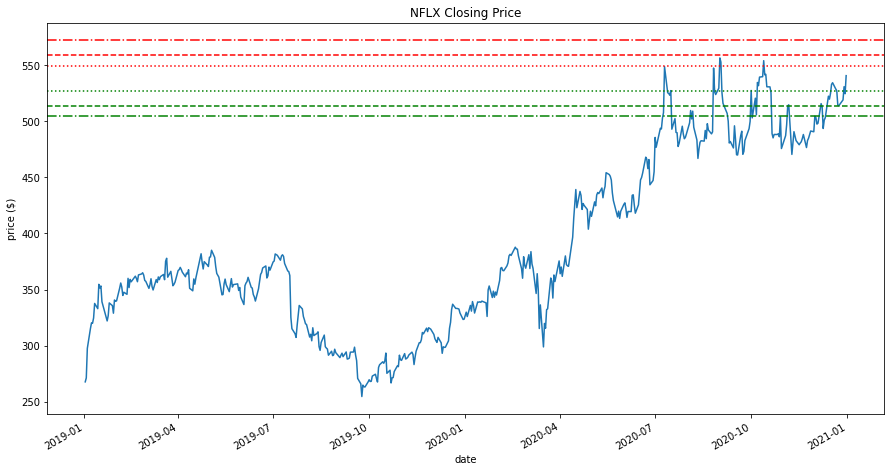

In [2]:
import itertools

def levels(analyzer, method):
    return [getattr(analyzer, method)(i) for i in range(1, 4)]

# calculate support/resistance levels
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (
    levels(nflx_analyzer, metric) for metric in ['support', 'resistance']
)

nflx_viz = stock_analysis.StockVisualizer(nflx)
ax = nflx_viz.evolution_over_time('close', figsize=(15, 8), title='NFLX Closing Price')

for support, resistance, linestyle, level in zip(
    support_levels, resistance_levels, 
    [':', '--', '-.'], itertools.count(1)
):
    nflx_viz.add_reference_line(
        ax, 
        y=support, 
        label=f'support level {level}', 
        color='green', 
        linestyle=linestyle
    )
    nflx_viz.add_reference_line(
        ax, 
        y=resistance, 
        label=f'resistance level {level}', 
        color='red', 
        linestyle=linestyle
    )
ax.get_legend().remove()
ax.set_ylabel('price ($)')

## Exercise 2
With the `StockVisualizer` class, look at the effect of after-hours trading on the FAANG stocks.
1. As individual stocks
2. As a portfolio using the sum of their closing and opening prices

### Part 1

array([[<AxesSubplot:title={'center':"Amazon Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Amazon after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Apple Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Apple after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Facebook Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Facebook after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Google Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Google after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Netflix Open Price - Prior Day's Close"}, xlabel='da

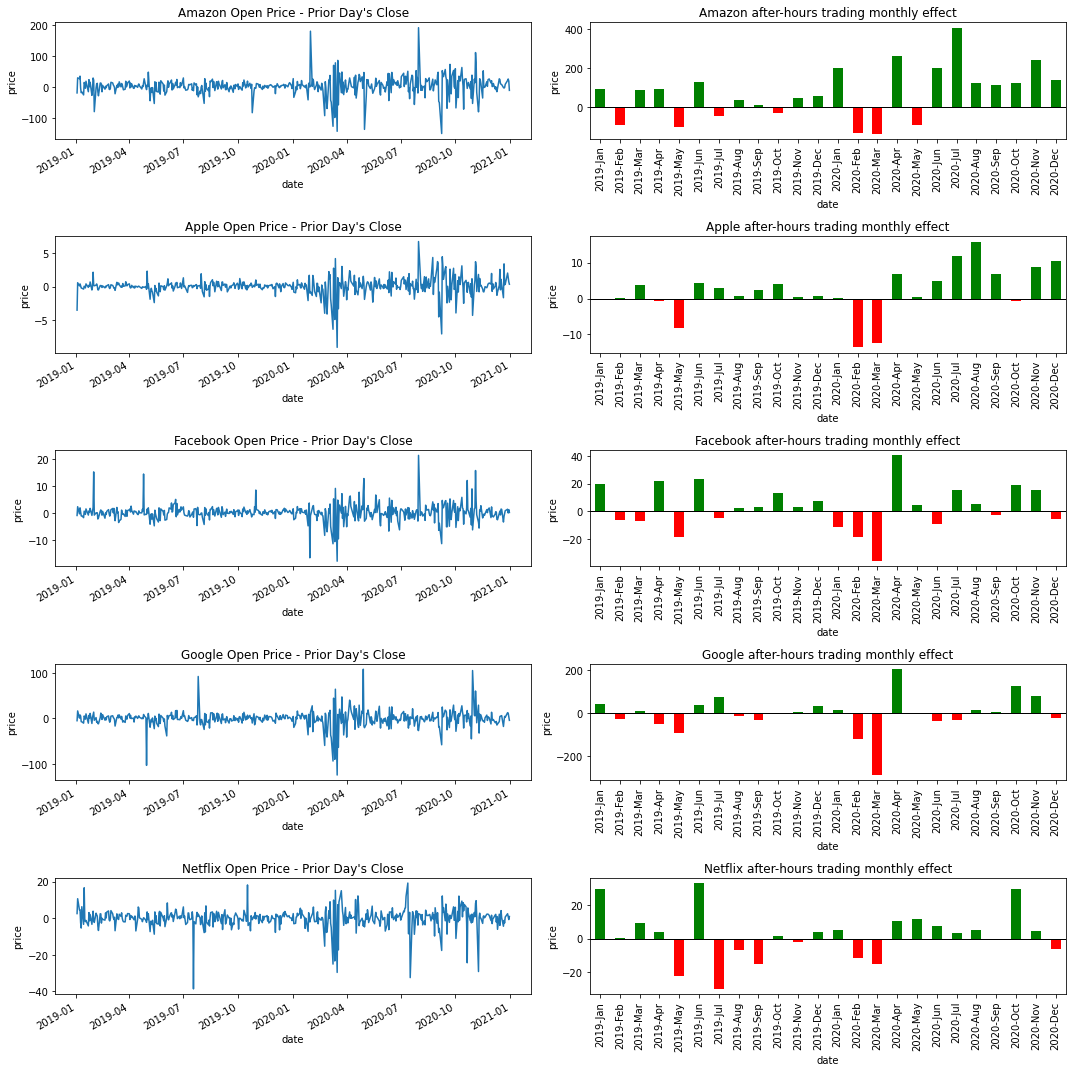

In [3]:
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()

### Part 2

array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

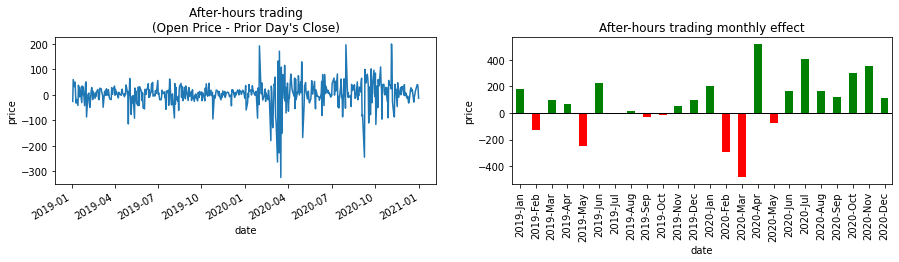

In [4]:
from stock_analysis.utils import make_portfolio

stock_analysis.StockVisualizer(make_portfolio(faang)).after_hours_trades()

## Exercise 3
### FAANG Portfolio
Using the `StockVisualizer.open_to_close()` method, create a plot that fills the area between the FAANG portfolio's opening price and its closing price each day in red if the price declined and in green if the price increased.

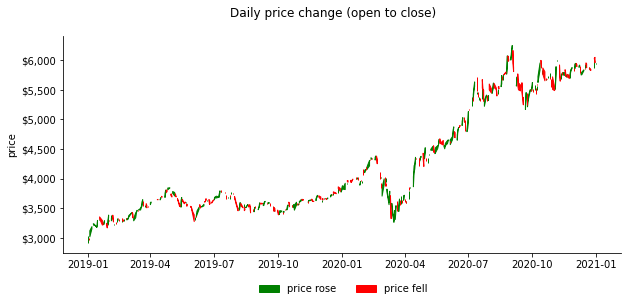

In [5]:
from matplotlib.ticker import StrMethodFormatter
from stock_analysis.utils import make_portfolio

ax = stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

### Bonus: Portfolio of S&P 500 and Bitcoin
Note that after reindexing the S&P 500 data, we can simply add it with the bitcoin data to get the portfolio value:

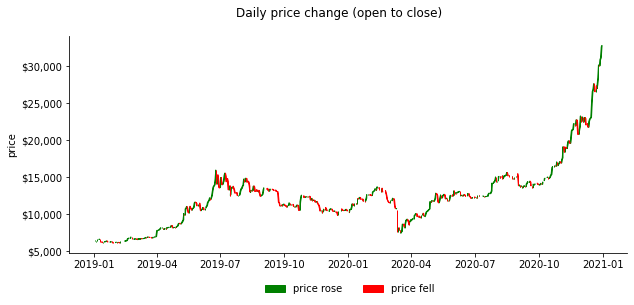

In [6]:
import pandas as pd
import numpy as np

def reindex_stock_data(df):
    """Handles reindexing of stock data"""
    result = df.copy().reindex(
        pd.date_range(start, end=end, freq='D')
    ).assign(
        volume=lambda x: x.fillna(0),
        close=lambda x: x.fillna(method='ffill'),
        open=lambda x: x.open.combine_first(x.close),
        high=lambda x: x.high.combine_first(x.close),
        low=lambda x: x.low.combine_first(x.close)
    )
    result.index.rename('date', inplace=True)
    return result

sp_reindexed = reindex_stock_data(sp)

ax = stock_analysis.StockVisualizer(bitcoin + sp_reindexed).open_to_close()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

## Exercise 4
Compare a mutual fund or ETF (Exchange Traded Fund) of your choice to 3 of its largest assets (by composition), using annualized volatility and the `AssetGroupAnalyzer` class. These funds are built to mitigate risk, so volatility for the fund will be lower than that of the assets that compose it.

*Note: Solution uses the mutual fund FBALX, whose composition can be found at https://fundresearch.fidelity.com/mutual-funds/composition/316345206. Composition used for the solution taken on January 9, 2021.*

In [7]:
fbalx = reader.get_ticker_data('FBALX')
msft = reader.get_ticker_data('MSFT')
mutual_fund = group_stocks({
    '0 - FBALX': fbalx,
    '1 - Microsoft': msft,
    '2 - Apple': aapl,
    '3 - Amazon': amzn
})
stock_analysis.AssetGroupAnalyzer(mutual_fund).analyze('annualized_volatility')

{'0 - FBALX': 0.24298784585130193,
 '1 - Microsoft': 0.4394683613426673,
 '2 - Apple': 0.4670809643500882,
 '3 - Amazon': 0.3851099077041784}

## Exercise 5
Write a function that returns a dataframe of one row with columns `alpha`, `beta`, `sharpe_ratio`, `annualized_volatility`, `is_bear_market`, and `is_bull_market` which each contain the results of running the respective methods on a given stock using the `StockAnalyzer` class. Here, we are using the 10-year US Treasury Bill for the risk-free rate of return. You can look up rates [here](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yield) or use the `StockReader.get_risk_free_rate_of_return()` method.

In [8]:
import pandas as pd

def metric_table(stock, index, r_f):
    """
    Make a table of metrics for a stock.

    Parameters:
        - stock: The stock's dataframe.
        - index: The dataframe for the index.
        - r_f: Risk-free rate of return
     
    Returns:
        A `pandas.DataFrame` object with a single row of metrics
    """
    return pd.DataFrame({
        metric: getattr(
            stock_analysis.StockAnalyzer(stock), 
            metric
        )(**kwargs) \
        for metric, kwargs in {
            'alpha': {'index': index, 'r_f': r_f}, 
            'beta': {'index': index}, 
            'sharpe_ratio': {'r_f': r_f},
            'annualized_volatility': {},
            'is_bear_market': {},
            'is_bull_market': {}
        }.items()
    }, index=range(1))

# test out the function
metric_table(fbalx, sp, r_f=reader.get_risk_free_rate_of_return())

,alpha,beta,sharpe_ratio,annualized_volatility,is_bear_market,is_bull_market
0,0.023815,0.683745,4.911228,0.242988,False,False


## Exercise 6

With the `StockModeler` class, build an ARIMA model fit on the S&P 500 data from January 1, 2019 through November 30, 2020 and use it to predict the performance in December 2020. Be sure to examine the residuals and compare the predicted performance to the actual performance.

First, isolate the data for training the model and testing it:

In [9]:
train, test = sp['2019':'2020-11'], sp.loc['2020-12']

Look at the autocorrelation plot:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

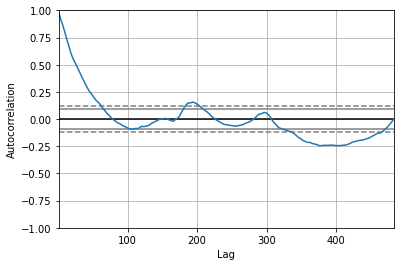

In [10]:
# we can use autocorrelation plots to find a good starting point for ARIMA
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train.close)

An example ARIMA model that fits in a reasonable amount of time:

In [11]:
%%capture
from stock_analysis import StockModeler
arima_model = StockModeler.arima(train, ar=15, i=1, ma=5)

Examine the residuals:

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

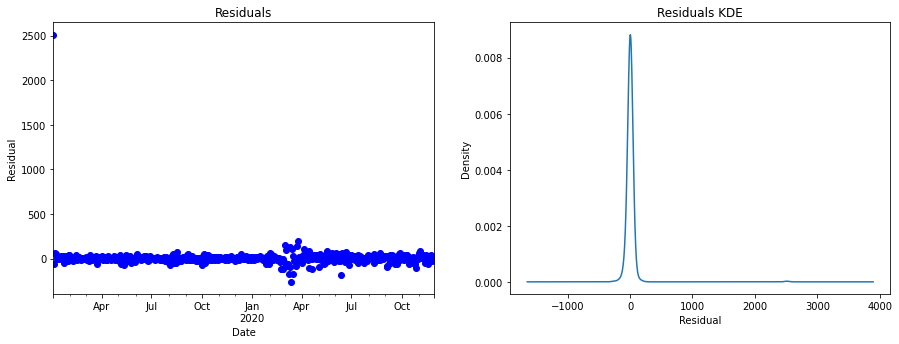

In [12]:
StockModeler.plot_residuals(arima_model)

Compare the ARIMA model's predictions to what actually happened:

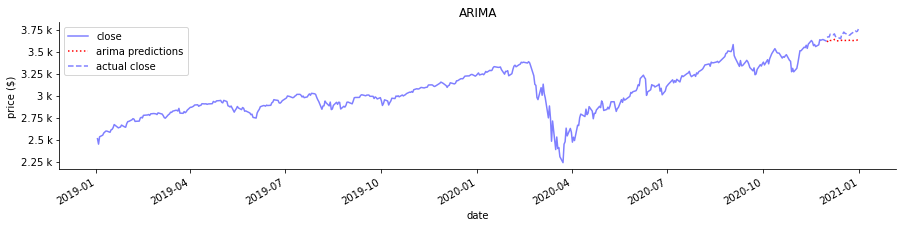

In [13]:
from matplotlib.ticker import EngFormatter

dates = test.index

arima_ax = StockModeler.arima_predictions(
    train, arima_model, start=dates[0], end=dates[-1],
    title='ARIMA', color='b', figsize=(15, 3), alpha=0.5
)
test.close.plot(ax=arima_ax, style='b--', label='actual close', alpha=0.5)
arima_ax.legend()
arima_ax.set_ylabel('price ($)')
arima_ax.yaxis.set_major_formatter(EngFormatter())

for spine in ['top', 'right']:
    arima_ax.spines[spine].set_visible(False)

## Exercise 7
Create an API key for AlphaVantage [here](https://www.alphavantage.co/support/#api-key) and collect the daily foreign exchange rate from USD to JPY using the `StockReader.get_forex_rates()` method. Be sure to use the same `StockReader` object you created to collect the stock data. Build a candlestick plot with the data from February 2019 through January 2020, resampled to one-week intervals. Hint: take a look at [the `slice()` function](https://docs.python.org/3/library/functions.html#slice) in order to provide the date range.

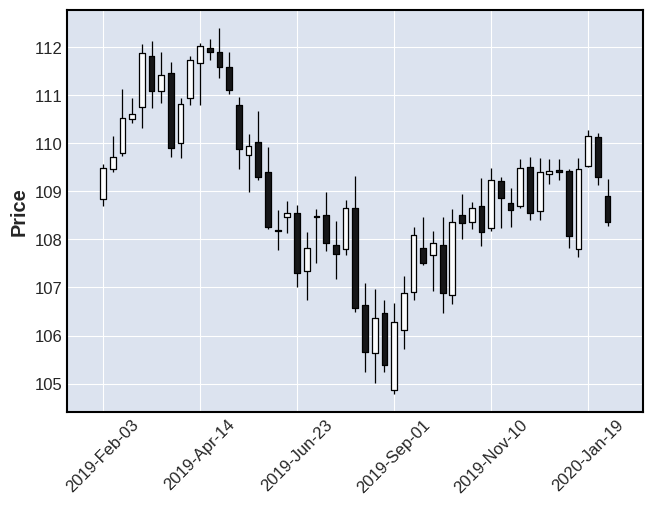

In [14]:
forex = reader.get_forex_rates('USD', 'JPY', api_key='PASTE_YOUR_API_KEY_HERE')
stock_analysis.StockVisualizer(forex).candlestick(date_range=slice('2019-02-01', '2020-01-31'), resample='1W')

<hr>
<div>
    <a href="../../ch_07/financial_analysis.ipynb">
        <button>&#8592; Chapter 7</button>
    </a>
    <a href="../../ch_08/anomaly_detection.ipynb">
        <button style="float: right;">Chapter 8 &#8594;</button>
    </a>
</div>
<hr>